In [1]:
import pandas as pd
import numpy as np
import pickle
from datetime import date
import holidays
import matplotlib.pyplot as plt
plt.style.use("bmh")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from sklearn.linear_model import LinearRegression

### Import 

In [2]:
df_bonn = pd.read_pickle("data/df_bonn.pickle")
df_weather_bonn = pd.read_pickle("data/df_weather_bonn.pickle")
df_essen = pd.read_pickle("data/df_essen.pickle")
df_weather_essen = pd.read_pickle("data/df_weather_essen.pickle")

---

### Feature Selection

Demand on a given day $:=$ number of bike rentals on that day 

In [3]:
# Add holiday, semester and school columns
holiday=holidays.Germany(years=[2019],prov='NW')

def isHoliday(day):
    return int(day in holiday)

def isSemester(day):
    isSemester = (date(2019,  4, 1) <= day < date(2019,  6, 10) or 
                  date(2019,  6, 15) <= day <= date(2019,  7, 12) or 
                  date(2019,  2, 1) == day)
    return int(isSemester)

def isSchool(day):
    isSchool = (day < date(2019,  4, 15) or 
                day > date(2019,  4, 27) and 
                date(2019,  6, 11) != day)
    return int(isSchool)

In [4]:
df_bonn["day"] = df_bonn["timestamp"].apply(lambda row: row.date())
df_bonn = df_bonn.drop(["timestamp"], axis=1)
df_demand_bonn = pd.DataFrame(df_bonn.groupby(["day"]).count()["b_number"])
df_demand_bonn = df_demand_bonn.rename(columns={"b_number": "demand"}) 
df_demand_bonn["isHoliday"] = df_demand_bonn.index.map(isHoliday)
df_demand_bonn["isWeekend"] = df_demand_bonn.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_bonn["isSemester"] = df_demand_bonn.index.map(isSemester)
df_demand_bonn["isSchool"] = df_demand_bonn.index.map(isSchool)
df_demand_bonn

demand  isHoliday  isWeekend  isSemester  isSchool
day                                                           
2019-02-01     904          0          0           1         1
2019-02-02     682          0          1           0         1
2019-02-03     624          0          1           0         1
2019-02-04     837          0          0           0         1
2019-02-05    1012          0          0           0         1
...            ...        ...        ...         ...       ...
2019-06-26    3625          0          0           1         1
2019-06-27    3829          0          0           1         1
2019-06-28    4259          0          0           1         1
2019-06-29    3275          0          1           1         1
2019-06-30    2476          0          1           1         1

[147 rows x 5 columns]

In [5]:
df_essen["day"] = df_essen["timestamp"].apply(lambda row: row.date())
df_essen = df_essen.drop(["timestamp"], axis=1)
df_demand_essen = pd.DataFrame(df_essen.groupby(["day"]).count()["b_number"])
df_demand_essen = df_demand_essen.rename(columns={"b_number": "demand"}) 
df_demand_essen["isHoliday"] = df_demand_essen.index.map(isHoliday)
df_demand_essen["isWeekend"] = df_demand_essen.index.map(lambda row: row.weekday()>=5).astype(int)
df_demand_essen["isSemester"] = df_demand_essen.index.map(isSemester)
df_demand_essen["isSchool"] = df_demand_essen.index.map(isSchool)
df_demand_essen

demand  isHoliday  isWeekend  isSemester  isSchool
day                                                           
2019-02-01      57          0          0           1         1
2019-02-02      30          0          1           0         1
2019-02-03      29          0          1           0         1
2019-02-04      49          0          0           0         1
2019-02-05      60          0          0           0         1
...            ...        ...        ...         ...       ...
2019-06-26     231          0          0           1         1
2019-06-27     272          0          0           1         1
2019-06-28     317          0          0           1         1
2019-06-29     174          0          1           1         1
2019-06-30     103          0          1           1         1

[147 rows x 5 columns]

In [6]:
df_weather_bonn["day"] = df_weather_bonn["timestamp"].apply(lambda row: row.date())
df_weather_bonn = df_weather_bonn.groupby(["day"]).mean()
df_weather_bonn

temperature_2m  dew_point_temperature_2m  relative_humidity  \
day                                                                       
2019-02-01        1.841667                 -0.279167          86.291667   
2019-02-02        1.516667                  1.179167          97.541667   
2019-02-03        1.558333                 -0.595833          86.250000   
2019-02-04        1.754167                 -2.758333          73.250000   
2019-02-05        3.087500                  0.462500          83.166667   
...                    ...                       ...                ...   
2019-06-26       26.679167                 17.854167          60.208333   
2019-06-27       21.745833                 10.620833          52.791667   
2019-06-28       20.325000                  9.983333          55.208333   
2019-06-29       24.145833                 10.525000          46.458333   
2019-06-30       25.037500                 14.650000          54.083333   

            precipitation  has_precipitated  wind_velocity_10m  \
day                                                              
2019-02-01       0.004167          0.333333           3.358333   
2019-02-02       0.179167          0.916667           1.683333   
2019-02-03       0.000000          0.250000           2.379167   
2019-02-04       0.000000          0.125000           3.762500   
2019-02-05       0.025000          0.666667           1.920833   
...                   ...               ...                ...   
2019-06-26       0.000000          0.000000           2.512500   
2019-06-27       0.000000          0.000000           2.854167   
2019-06-28       0.000000          0.000000           1.741667   
2019-06-29       0.000000          0.000000           2.329167   
2019-06-30       0.000000          0.000000           2.587500   

            wind_direction_10m  mean_wind_speed_10m  mean_wind_direction_10m  \
day                                                                            
2019-02-01          124.166667             3.495833               126.666667   
2019-02-02          237.500000             1.633333               210.416667   
2019-02-03          297.916667             2.425000               303.333333   
2019-02-04          184.583333             3.658333               187.083333   
2019-02-05          168.333333             1.979167               170.833333   
...                        ...                  ...                      ...   
2019-06-26          303.750000             2.420833               305.416667   
2019-06-27          242.916667             2.891667               255.000000   
2019-06-28          234.583333             1.741667               243.750000   
2019-06-29          104.583333             2.337500               107.083333   
2019-06-30          240.416667             2.529167               241.250000   

            air_pressure_station_level  air_pressure_sea_level  \
day                                                              
2019-02-01                  970.916667              990.366667   
2019-02-02                  978.595833              998.220833   
2019-02-03                  999.583333             1019.641667   
2019-02-04                 1007.412500             1027.616667   
2019-02-05                 1007.895833             1027.987500   
...                                ...                     ...   
2019-06-26                 1004.325000             1022.675000   
2019-06-27                 1007.029167             1025.770833   
2019-06-28                 1004.850000             1023.662500   
2019-06-29                  999.787500             1018.270833   
2019-06-30                  995.754167             1014.075000   

            cloud_coverage  soil_temperature_5cm  soil_temperature_10cm  \
day                                                                       
2019-02-01        7.125000              0.425000               0.687500   
2019-02-02        7.750000              0.454167    

In [7]:
df_weather_essen["day"] = df_weather_essen["timestamp"].apply(lambda row: row.date())
df_weather_essen = df_weather_essen.groupby(["day"]).mean()
df_weather_essen

temperature_2m  dew_point_temperature_2m  relative_humidity  \
day                                                                       
2019-02-01        2.000000                 -0.641667          83.250000   
2019-02-02        0.625000                 -0.500000          92.166667   
2019-02-03        1.437500                 -1.370833          82.416667   
2019-02-04        1.766667                 -3.108333          71.791667   
2019-02-05        2.487500                  1.108333          90.791667   
...                    ...                       ...                ...   
2019-06-26       24.933333                 17.929167          66.083333   
2019-06-27       19.308333                 10.808333          60.416667   
2019-06-28       18.812500                  9.429167          57.208333   
2019-06-29       25.450000                 10.029167          41.541667   
2019-06-30       25.591667                 13.433333          47.208333   

            precipitation  has_precipitated  wind_velocity_10m  \
day                                                              
2019-02-01       0.062500          0.250000           3.100000   
2019-02-02       0.554167          0.791667           2.887500   
2019-02-03       0.000000          0.000000           2.495833   
2019-02-04       0.000000          0.166667           4.075000   
2019-02-05       0.045833          0.291667           2.725000   
...                   ...               ...                ...   
2019-06-26       0.000000          0.000000           3.241667   
2019-06-27       0.000000          0.000000           3.883333   
2019-06-28       0.000000          0.000000           3.262500   
2019-06-29       0.000000          0.000000           1.991667   
2019-06-30       0.000000          0.000000           3.470833   

            wind_direction_10m  mean_wind_speed_10m  mean_wind_direction_10m  \
day                                                                            
2019-02-01          127.500000             3.062500               129.166667   
2019-02-02           67.916667             2.820833                55.416667   
2019-02-03          297.916667             2.450000               312.500000   
2019-02-04          195.416667             4.045833               197.916667   
2019-02-05          199.583333             2.712500               201.250000   
...                        ...                  ...                      ...   
2019-06-26          222.916667             3.158333               238.750000   
2019-06-27           70.833333             3.887500                99.166667   
2019-06-28           51.666667             3.370833                51.250000   
2019-06-29          139.166667             1.975000               143.750000   
2019-06-30          250.416667             3.425000               247.083333   

            air_pressure_station_level  air_pressure_sea_level  \
day                                                              
2019-02-01                  971.979167              990.158333   
2019-02-02                  980.412500              998.825000   
2019-02-03                 1000.904167             1019.654167   
2019-02-04                 1007.329167             1026.179167   
2019-02-05                 1008.550000             1027.366667   
...                                ...                     ...   
2019-06-26                 1006.029167             1023.279167   
2019-06-27                 1009.337500             1027.029167   
2019-06-28                 1006.995833             1024.691667   
2019-06-29                 1000.966667             1018.158333   
2019-06-30                  996.841667             1013.933333   

            cloud_coverage  soil_temperature_5cm  soil_temperature_10cm  \
day                                                                       
2019-02-01        7.083333              0.300000               0.600000   
2019-02-02        7.750000              0.300000    

In [8]:
# Join demand and weather data (Bonn)
df_bonn = df_demand_bonn.join(df_weather_bonn, on="day", how="outer")
df_bonn = df_bonn[df_bonn.index.notna()] # remove entries where data is NaT
df_bonn = df_bonn.drop(["day"], axis=1)

# Join demand and weather data (Essen)
df_essen = df_demand_essen.join(df_weather_essen, on="day", how="outer")
df_essen = df_essen[df_essen.index.notna()] # remove entries where data is NaT
df_essen = df_essen.drop(["day"], axis=1)

In [9]:
# Plot a simple linear regression between demand and every other feature
def plot_all_features(city):
    df = df_bonn if city=="Bonn" else df_essen
    for i, feature in enumerate(df_bonn.columns[1:]):
        fig, ax = plt.subplots(figsize=(12, 4))
        ax.set_title(f"{feature} vs Demand", fontsize=16, fontweight="bold", pad=20)
        ax.set_xlabel(feature)
        ax.set_ylabel("demand")
        ax.scatter(df[feature], df["demand"], marker="x", label="Observation on a specific day")
        
        # Simple linear regression
        df_dropped = df[[feature, "demand"]].dropna() 
        X = pd.DataFrame(df_dropped[feature])
        y = df_dropped["demand"]
        model = LinearRegression()
        model.fit(X, y)
        x_space = np.linspace(df[feature].min(), df[feature].max(), 100).reshape(100, 1)
        y_pred = model.predict(x_space)
        ax.plot(x_space, y_pred, c="red", label="Linear Regression")
        ax.legend(loc="lower right")

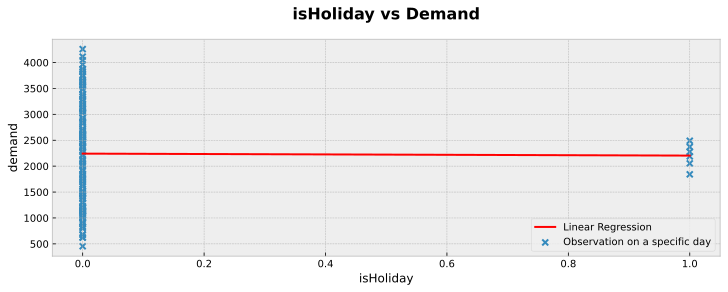

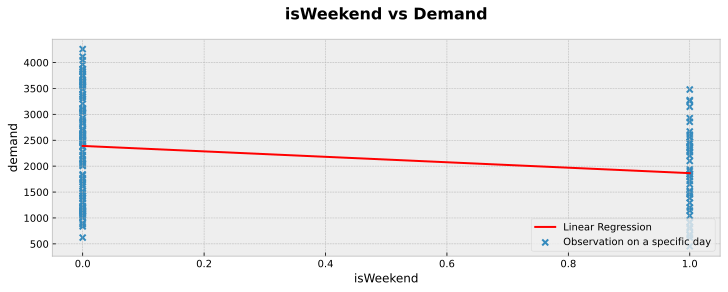

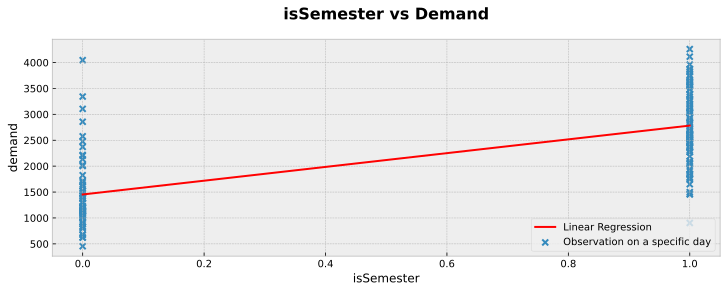

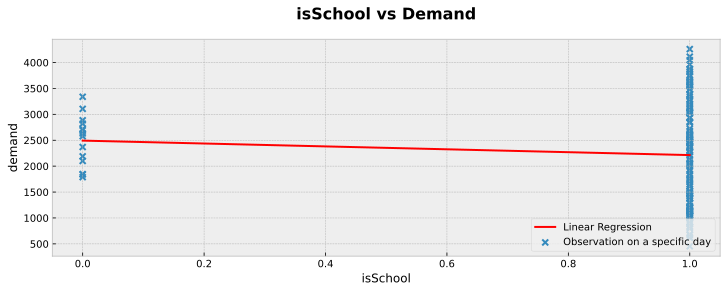

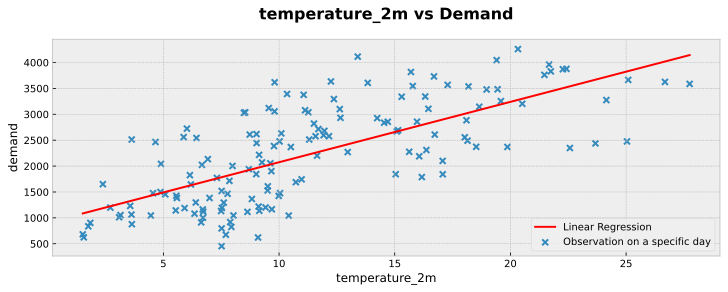

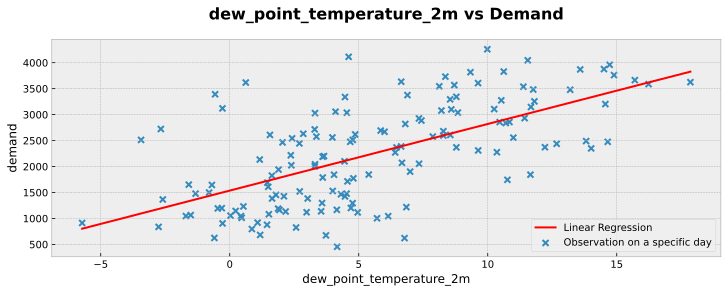

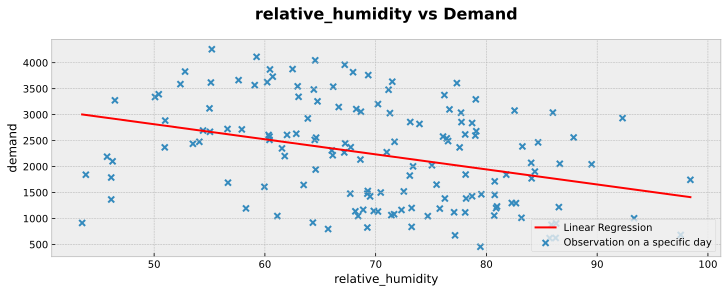

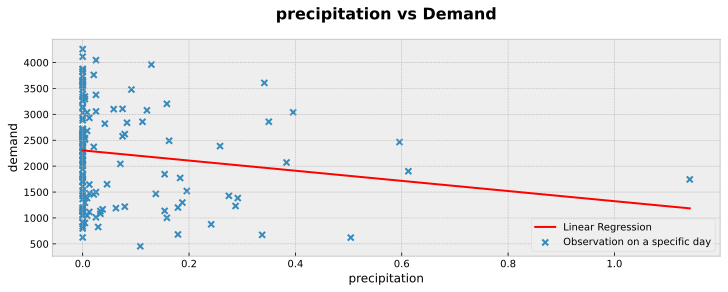

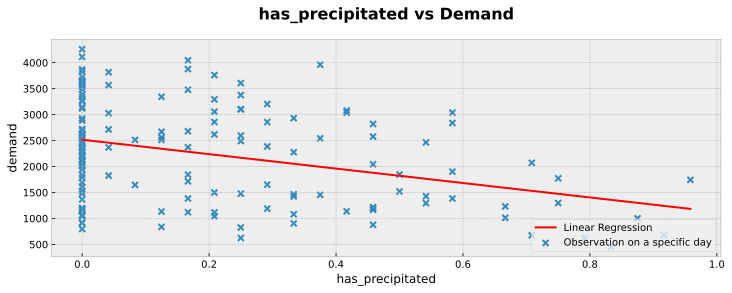

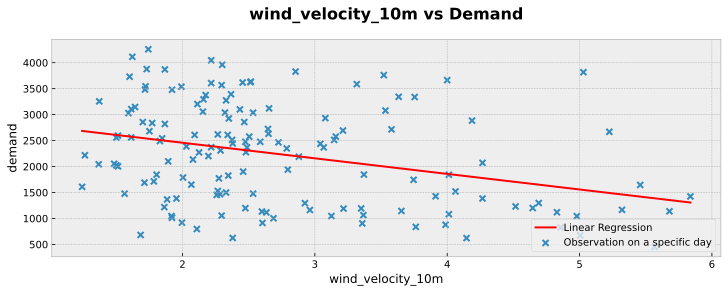

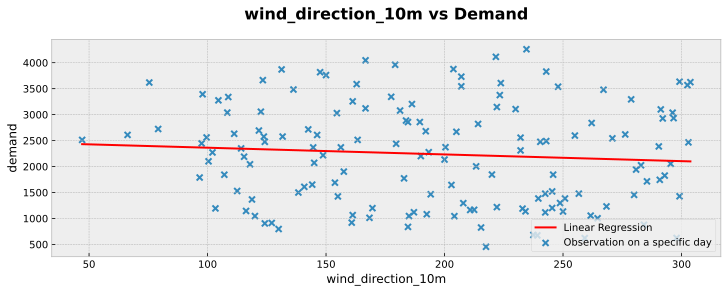

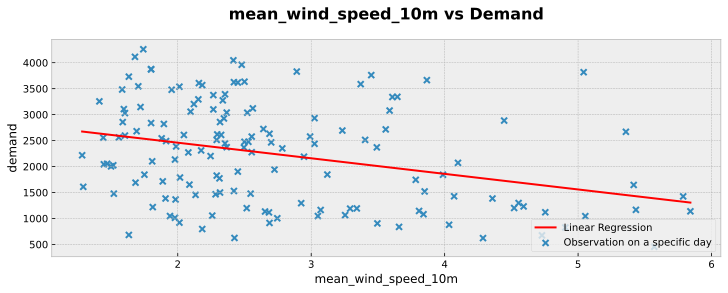

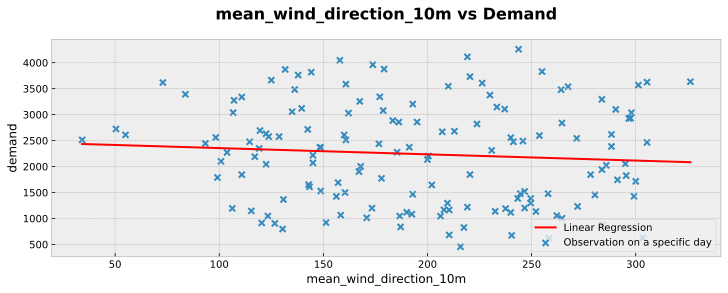

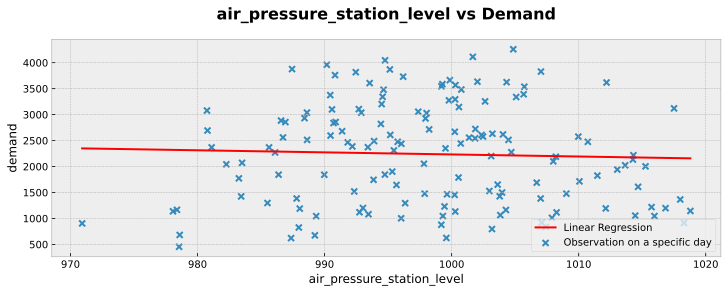

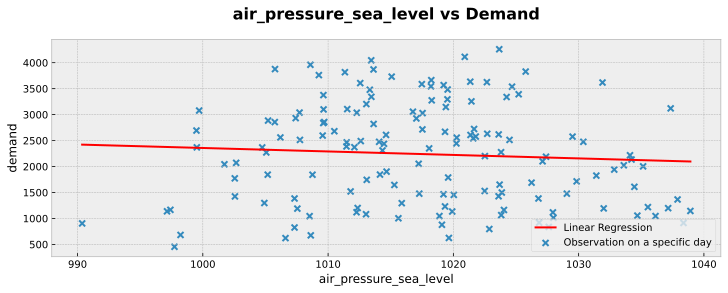

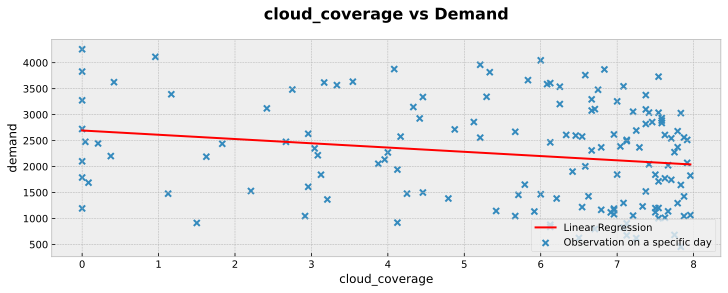

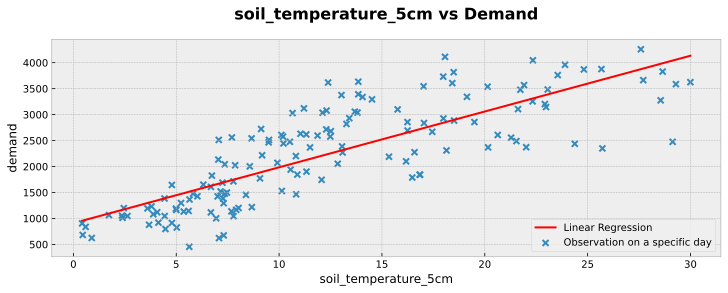

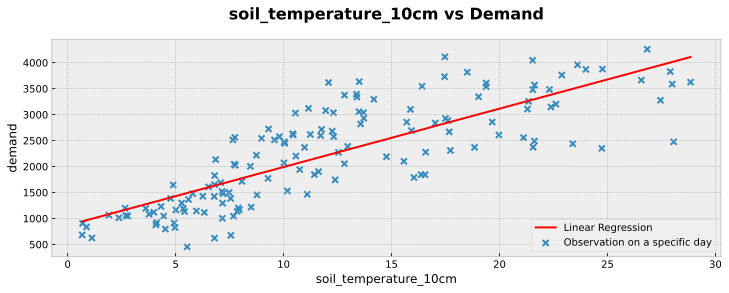

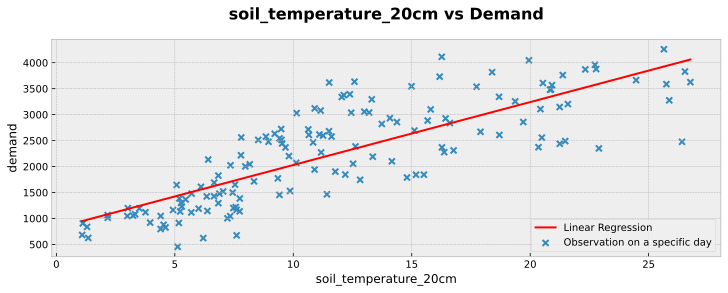

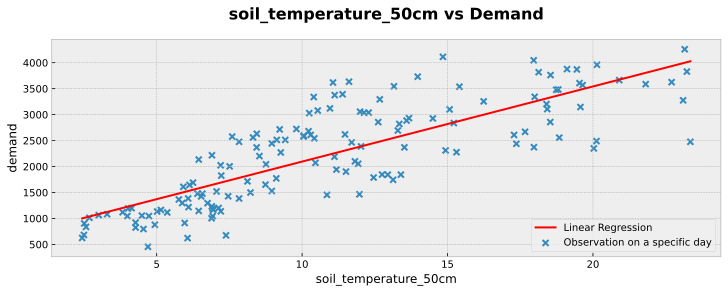

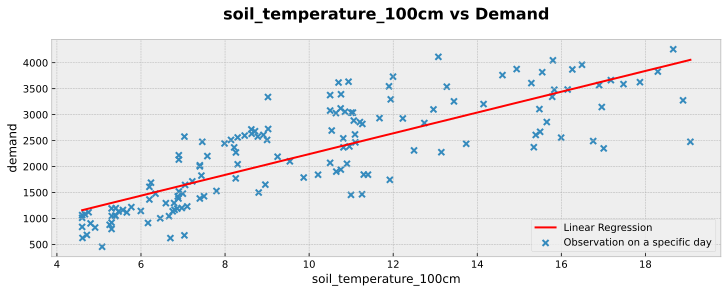

In [10]:
plot_all_features("Bonn")

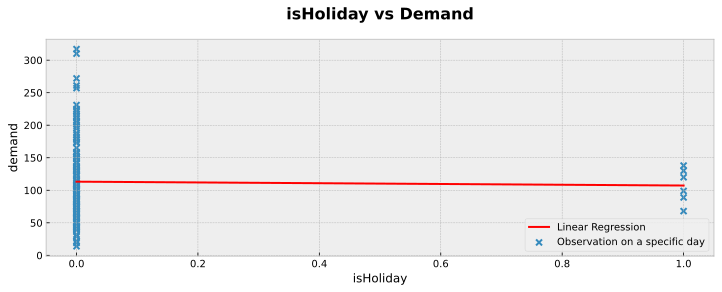

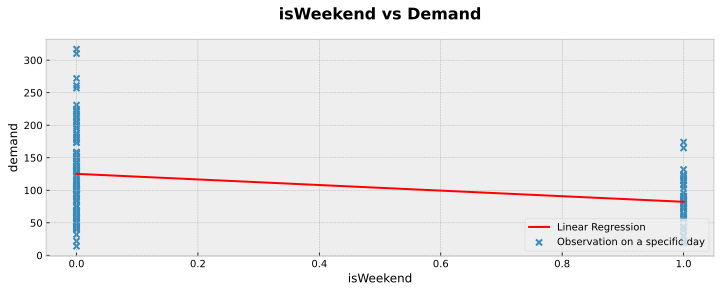

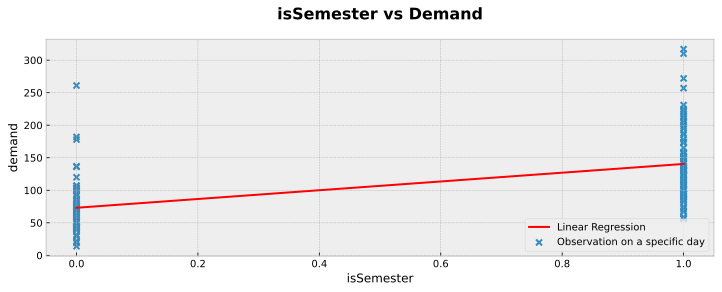

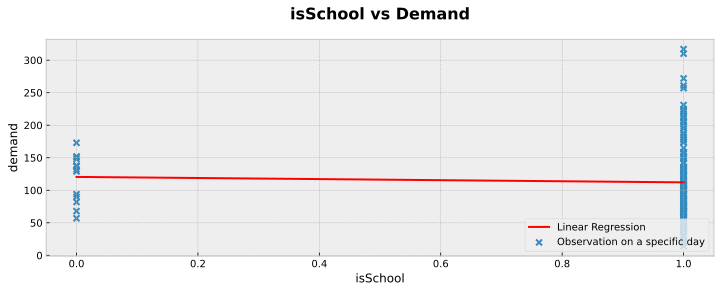

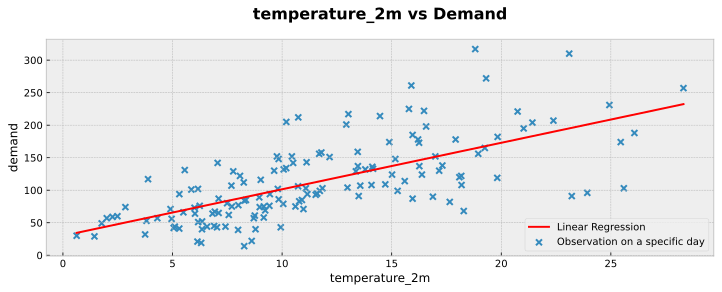

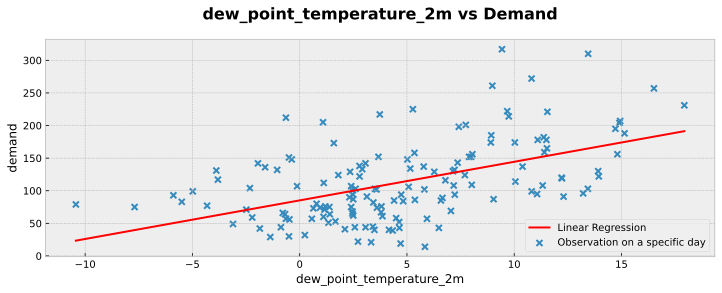

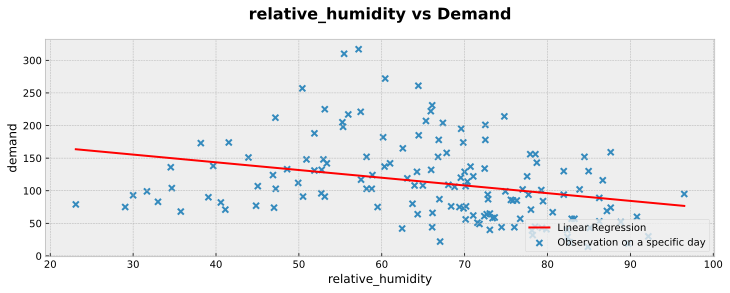

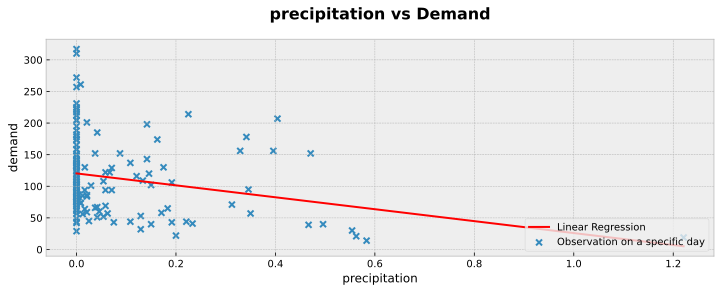

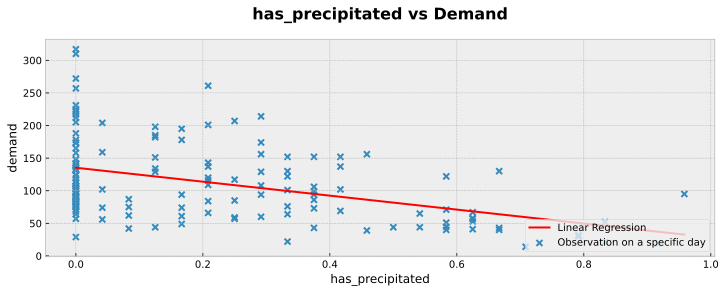

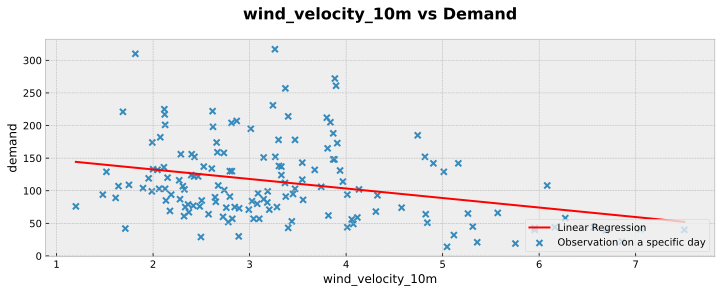

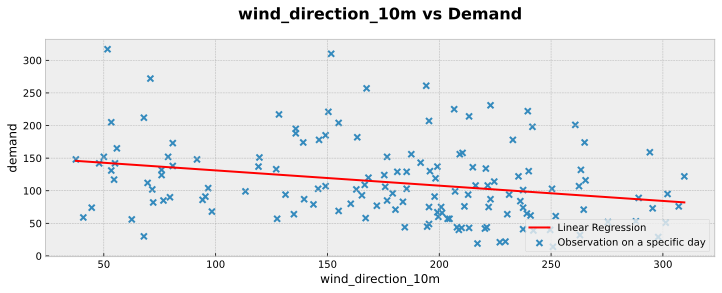

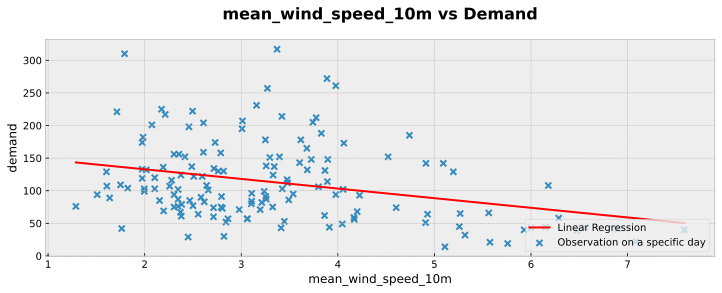

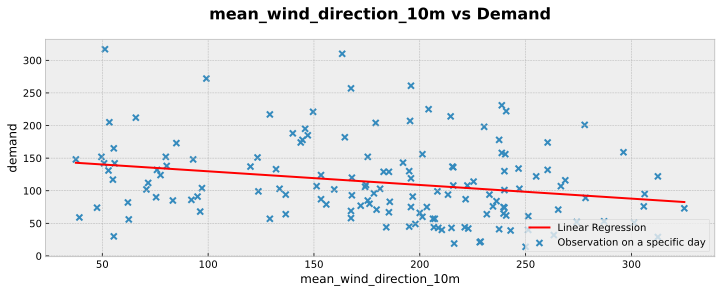

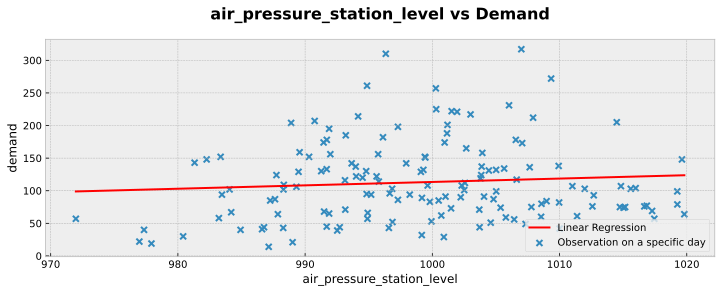

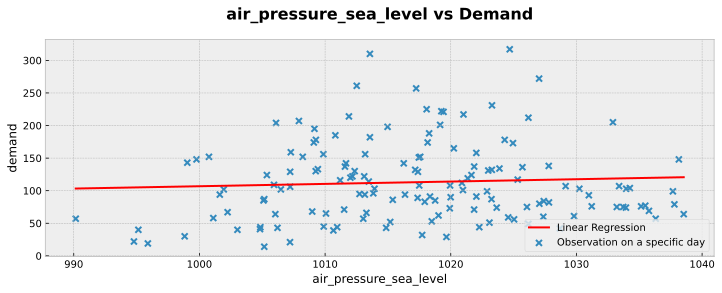

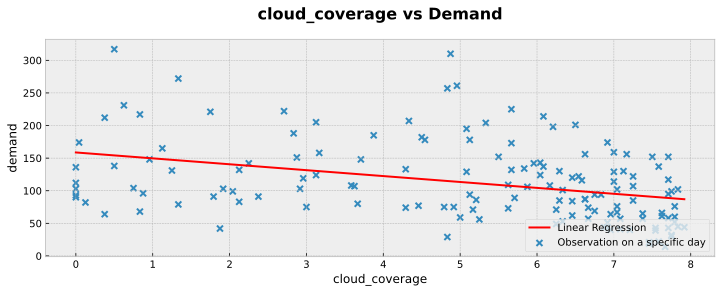

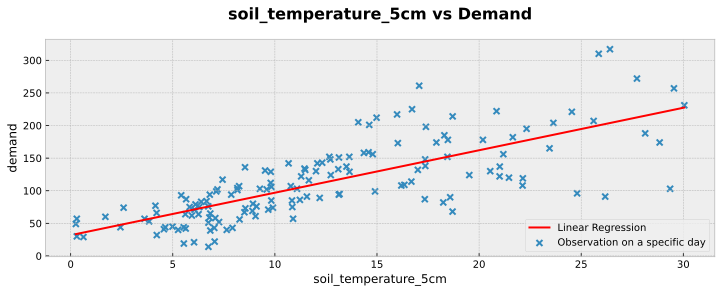

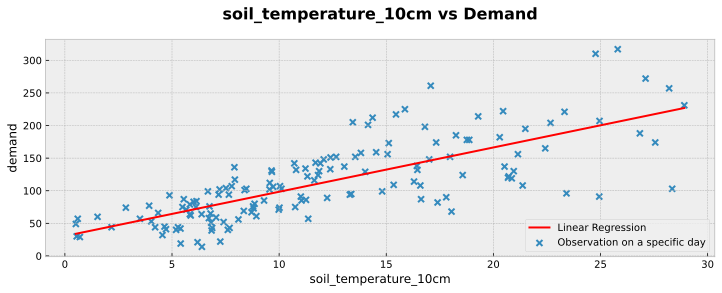

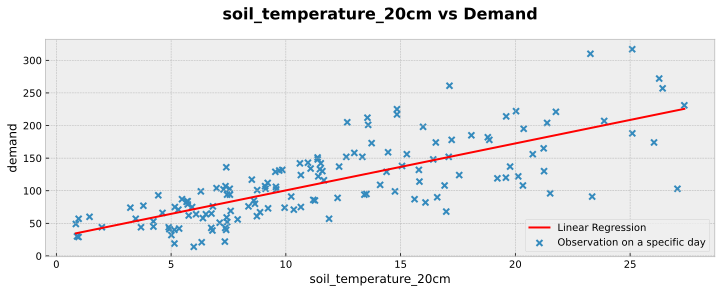

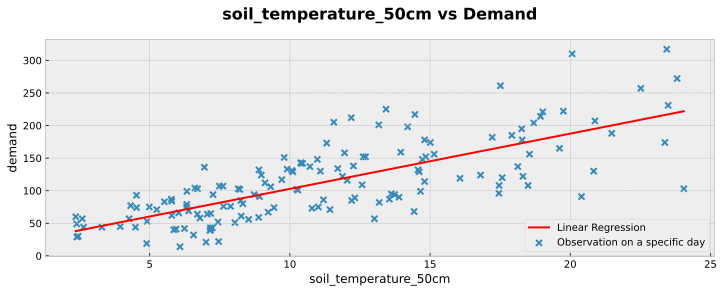

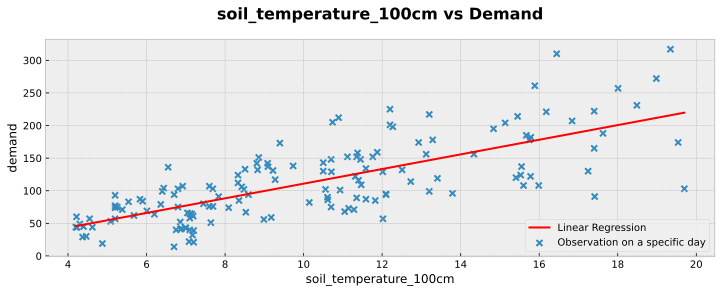

In [11]:
plot_all_features("Essen")

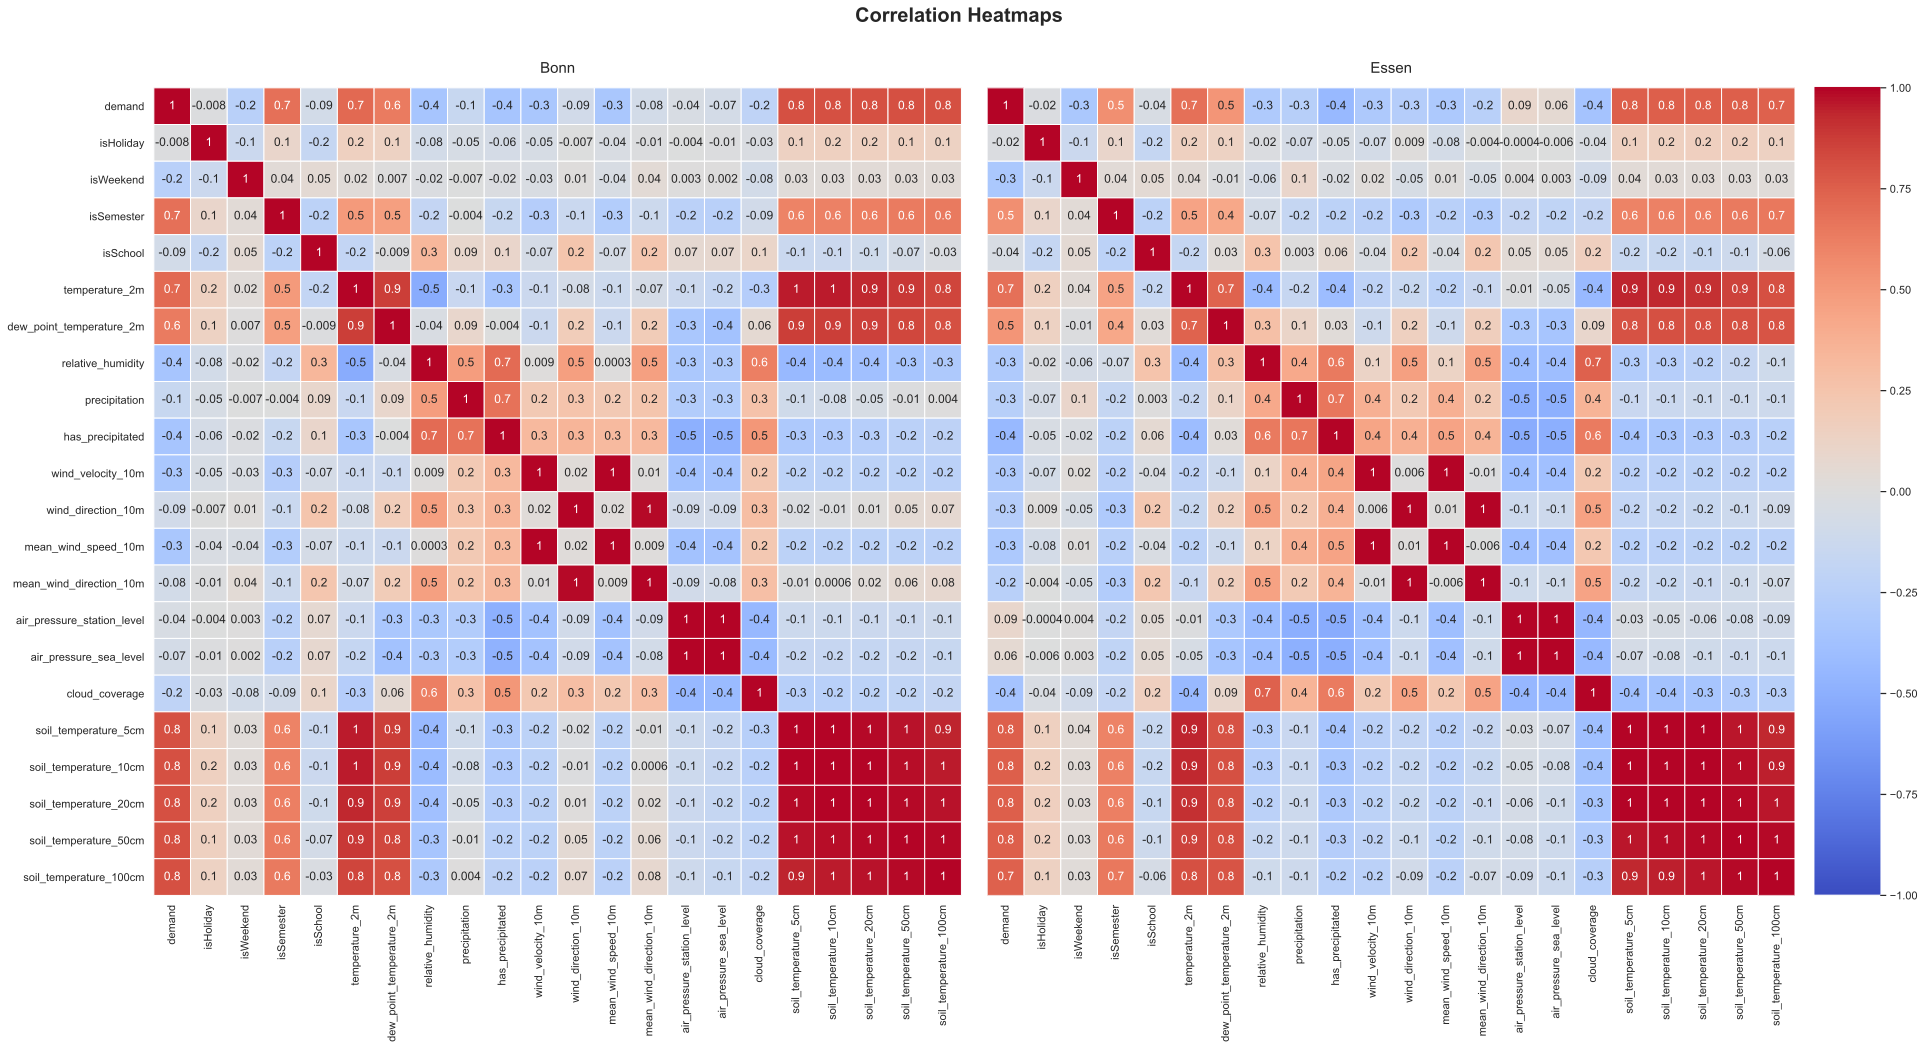

In [12]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(27,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('heatmaps.png', bbox_inches='tight')
plt.show()

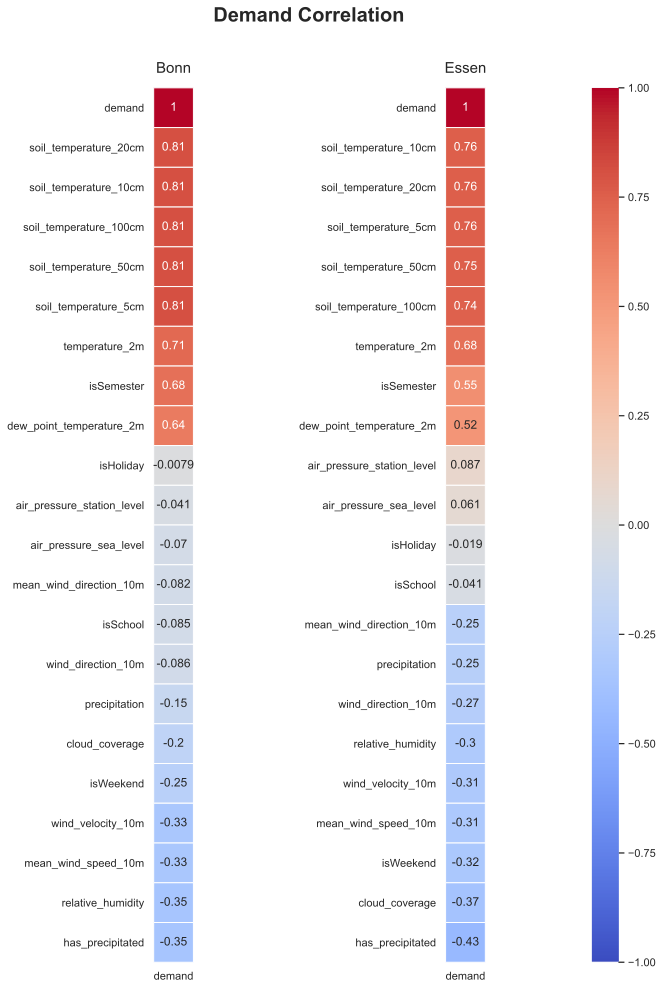

In [19]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(10,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)

g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_title("Essen", fontsize=15, pad=15)

f.tight_layout()
f.suptitle('Demand Correlation', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('Demand Correlation.png', bbox_inches='tight')
plt.show()

In [29]:
# Change isSemester and isSchool (day has to be weekday)
df_bonn["isSemester"] = np.maximum(0, df_bonn["isSemester"] - df_bonn["isWeekend"])
df_bonn["isSchool"] = np.maximum(0, df_bonn["isSchool"] - df_bonn["isWeekend"])

df_essen["isSemester"] = np.maximum(0, df_essen["isSemester"] - df_essen["isWeekend"])
df_essen["isSchool"] = np.maximum(0, df_essen["isSchool"] - df_essen["isWeekend"])

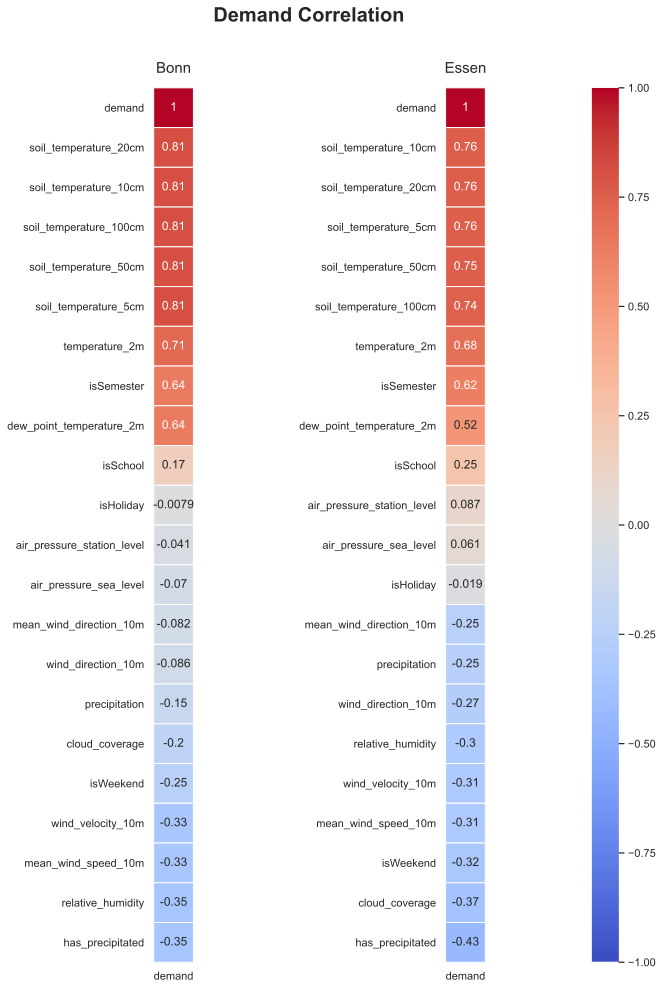

In [30]:
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(10,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)

g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr()[['demand']].sort_values(by='demand', ascending=False), 
                 annot = True, 
                 fmt='.2g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_title("Essen", fontsize=15, pad=15)

f.tight_layout()
f.suptitle('Demand Correlation', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('Demand Correlation.png', bbox_inches='tight')
plt.show()

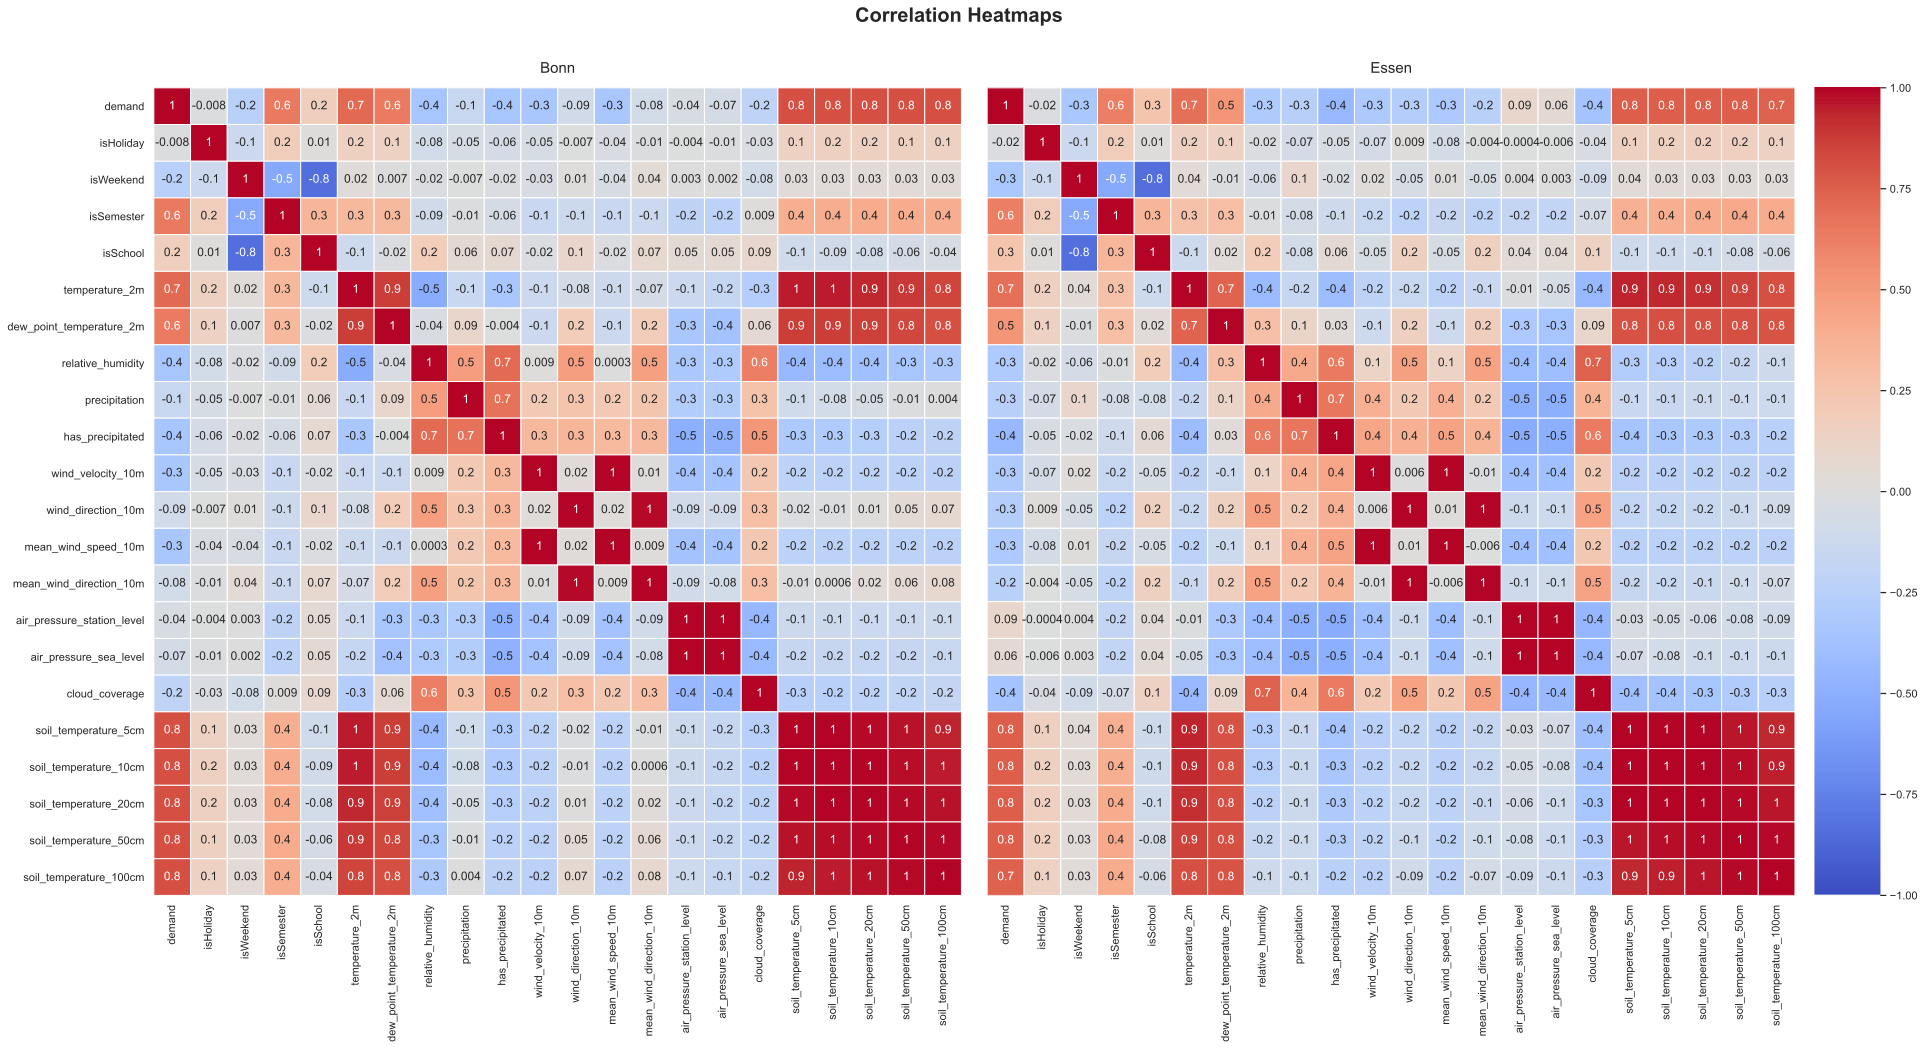

In [31]:
sns.set_theme()
f,(ax1,ax2, axcb) = plt.subplots(1,3, 
                                 gridspec_kw={'width_ratios':[1,1,0.08]}, 
                                 figsize=(27,14))
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(df_bonn.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 cbar=False, 
                 ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g1.set_title("Bonn", fontsize=15, pad=15)
g2 = sns.heatmap(df_essen.corr(), 
                 annot = True, 
                 fmt='.1g', 
                 vmin=-1, 
                 vmax=1, 
                 center=0, 
                 cmap='coolwarm', 
                 linewidths=1, 
                 square=True, 
                 ax=ax2, 
                 cbar_ax=axcb)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])
g2.set_title("Essen", fontsize=15, pad=15)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=90)
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0)

f.tight_layout()
f.suptitle('Correlation Heatmaps', fontweight="bold", fontsize=20)
f.subplots_adjust(top=0.9)

#plt.savefig('heatmaps.png', bbox_inches='tight')
plt.show()